- Read HSI csv files and observation summary xls file 
- Validate whether they match well
- Calculate mean emission by platform
- Export summary to one csv file

In [1]:
import os
from glob import glob
from itertools import chain
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
from sklearn.metrics.pairwise import haversine_distances
from math import radians
from matplotlib.ticker import FuncFormatter, AutoMinorLocator

In [2]:
from matplotlib import rcParams
font_size = 17
rcParams['axes.titlesize'] = font_size - 1
rcParams['axes.titleweight'] = 'bold'
rcParams['axes.labelsize'] = font_size - 2
rcParams['xtick.labelsize'] = font_size - 2
rcParams['ytick.labelsize'] = font_size - 2
rcParams['legend.fontsize'] = font_size
rcParams['figure.titlesize'] = font_size 
rcParams['figure.titleweight'] = 'bold'

## Read data

In [3]:
df = pd.read_excel('../data/landfills_hyper_obs.xlsx')

# remove space at end
df['name'] = df['name'].str.strip()

In [4]:
df_any_plume = df[(df['plume(emit)'] > 0) | (df['plume(enmap)'] > 0) | (df['plume(emit)'] > 0)]

In [5]:
def distance(row):
  location1_radian = [radians(_) for _ in [row['latitude'], row['longitude']]]
  location2_radian = [radians(_) for _ in [row['latitude_imeo'], row['longitude_imeo']]]
  result = haversine_distances([location1_radian, location2_radian])
  result = result * 6371000/1000  # multiply by Earth radius to get kilometers

  return result[0][1]

df_any_plume[~df_any_plume['name_imeo'].isna()].apply(distance, axis=1)

0      2.469481
2      0.446089
8      0.449981
9      0.000000
14     0.561375
17     1.004246
18     2.024497
24     0.616425
27     0.293877
36     0.122080
37    32.045020
38     0.410876
40     1.435000
41     0.378171
43     1.247128
49     6.756630
57     0.373522
59     0.389182
66     0.505175
68     3.761195
70     0.731854
73     0.671270
76     0.492830
79     0.771025
dtype: float64

In [6]:
data_dir = '../data/Hyper_TROPOMI_plume/'

filelist = list(chain(*[glob(os.path.join(data_dir, '**', '*csv'), recursive=True)]))

df_hyper = pd.concat((pd.read_csv(f, converters={'wind_source_all': literal_eval, 'wind_speed_all': literal_eval,
       'wind_direction_all': literal_eval}) for f in filelist), ignore_index=True)

# add shape error
df_hyper['emission_uncertainty'] = np.sqrt(df_hyper['emission_uncertainty']**2+(df_hyper['emission']*0.05)**2)
# add percentage error
df_hyper['emission_uncertainty(%)'] = df_hyper['emission_uncertainty']/df_hyper['emission']*100

# convert units from kg/h to t/h
df_hyper['emission'] = df_hyper['emission']/1e3

df_emiss = df_hyper.groupby(['country', 'name', 'platform'], as_index=False)\
    .agg({'plume_longitude':'mean', 'plume_latitude':'mean', 'emission':'mean',
          'emission_uncertainty(%)': 'mean', 'plume_id': 'count'})\
    .rename(columns={'plume_id': 'plume_count'})

# remove space at end
df_emiss['name'] = df_emiss['name'].str.strip()

## Check plume mask parameters

In [7]:
df_hyper.columns

Index(['plume_id', 'plume_latitude', 'plume_longitude', 'datetime', 'country',
       'state', 'city', 'name', 'ipcc_sector', 'gas', 'cmf_type',
       'plume_bounds', 'instrument', 'platform', 'emission',
       'emission_uncertainty', 'emission_uncertainty_random',
       'emission_uncertainty_wind', 'wind_speed', 'wind_direction',
       'wind_source', 'ueff_ime', 'alpha1', 'alpha2', 'alpha3', 'niter',
       'size_median', 'sigma_guass', 'quantile', 'wind_weights',
       'source_tropomi', 'source_trace', 'leff_ime', 'ime', 'emission_fetch',
       'emission_fetch_uncertainty', 'emission_fetch_uncertainty_ime',
       'emission_fetch_uncertainty_wind', 'wind_source_all', 'wind_speed_all',
       'wind_direction_all', 'emission_uncertainty(%)'],
      dtype='object')

<Axes: >

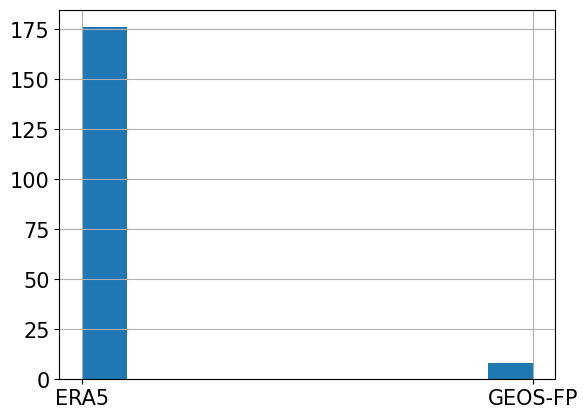

In [8]:
df_hyper['wind_source'].hist()

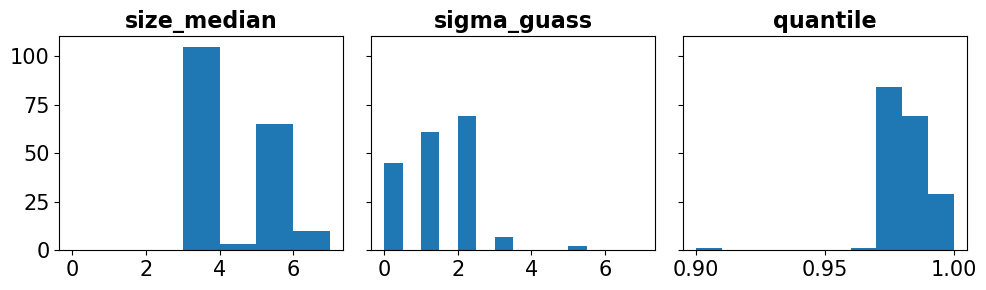

In [9]:
fig, axs = plt.subplots(ncols=3, figsize=(10, 3), sharey=True)

df_hyper.hist(column=['size_median'], ax=axs[0], bins=np.arange(8))
df_hyper.hist(column=['sigma_guass'], ax=axs[1], bins=np.arange(15)/2)
df_hyper.hist(column=['quantile'], ax=axs[2], bins=np.arange(0.9, 1.01, 0.01))

fig.tight_layout()

for ax in axs:
    ax.grid(False)

## Comparison between ERA5 and GEOS-FP

In [10]:
wspd_era5 = np.array([i[0] for i in df_hyper['wind_speed_all']])
wspd_geosfp = np.array([i[1] for i in df_hyper['wind_speed_all']])

In [11]:
u_eff_era5 = df_hyper['alpha1'] * np.log(wspd_era5) + df_hyper['alpha2'] + df_hyper['alpha3'] * wspd_era5
u_eff_geosfp = df_hyper['alpha1'] * np.log(wspd_geosfp) + df_hyper['alpha2'] + df_hyper['alpha3'] * wspd_geosfp

Q_era5 = u_eff_era5 / df_hyper['leff_ime'] * df_hyper['ime'] * 3600 / 1e3  # t/h
Q_geosfp = u_eff_geosfp / df_hyper['leff_ime'] * df_hyper['ime'] * 3600 / 1e3  # t/h

<Axes: >

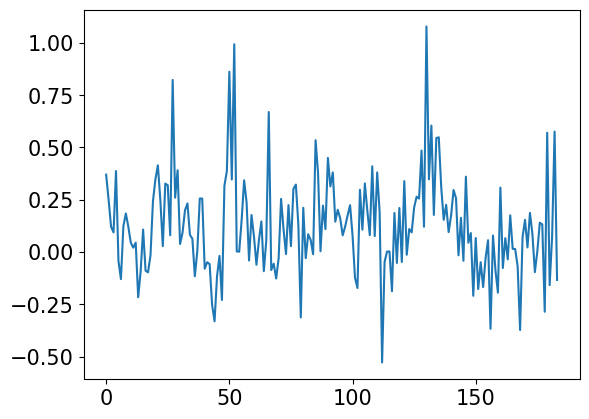

In [12]:
((Q_geosfp-Q_era5)/Q_era5).plot()

In [13]:
print('Mean percentage difference between Q_GEOSFP and Q_ERA5: ', ((Q_geosfp-Q_era5)/Q_era5).mean()*100)

Mean percentage difference between Q_GEOSFP and Q_ERA5:  12.392243031592553


0.5468651091255962


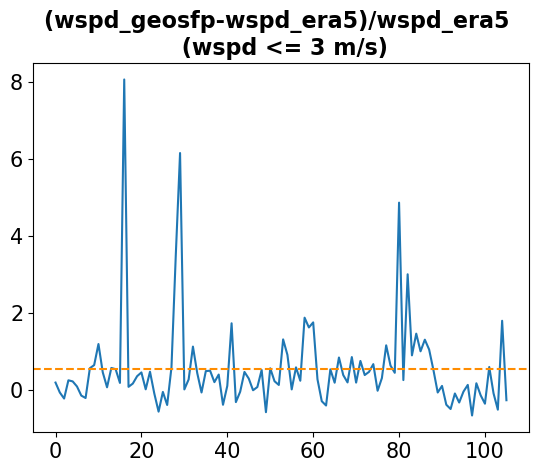

In [14]:
diff_highwspd = (wspd_geosfp[wspd_era5<=3]-wspd_era5[wspd_era5<=3])/wspd_era5[wspd_era5<=3]
plt.plot(diff_highwspd)
plt.title('(wspd_geosfp-wspd_era5)/wspd_era5 \n (wspd <= 3 m/s)')
plt.axhline(y=diff_highwspd.mean(), color='darkorange', linestyle='--')
print(diff_highwspd.mean())

0.435756898783015


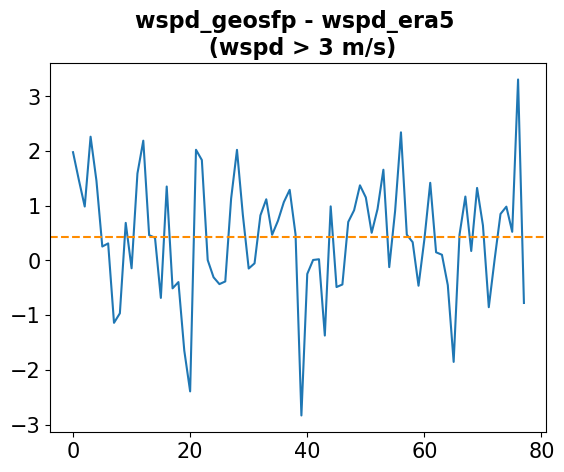

In [15]:
diff_lowwspd = wspd_geosfp[wspd_era5>3]-wspd_era5[wspd_era5>3]
plt.plot(diff_lowwspd, label='diff')
plt.title('wspd_geosfp - wspd_era5 \n (wspd > 3 m/s)')
plt.axhline(y=diff_lowwspd.mean(), color='darkorange', linestyle='--')
# plt.legend()
print(diff_lowwspd.mean())

We compare the ERA5 and GEOS-FP wind reanalysis data, and find that the error falls within the predefined wind error margin:

- uncertainty = 50%, if wspd <= 3 m/s
- uncertainty = 1.5 m/s, if wspd > 3 m/s

## Validate csv and excel files

In [16]:
def validate_name(df_emiss, df):
    csv_name = df_emiss['name'].drop_duplicates()
    excel_name = df['name'].drop_duplicates()
    name_valid = csv_name.isin(excel_name)
    if all(name_valid):
        print('All csv landfill names are in the excel file')
    else:
        print(csv_name[~name_valid], 'is not in the excel file')

def append_excel_data(row, df):
    count = df[df['name']==row['name']][f"plume({row['platform'].lower()})"].item()
    overpass = df[df['name']==row['name']][f"overpass({row['platform'].lower()})"].item()

    return int(count), int(overpass)

In [17]:
validate_name(df_emiss, df)

All csv landfill names are in the excel file


In [18]:
df_emiss['count'], df_emiss['overpass'] = zip(*df_emiss.apply(append_excel_data, args=(df,), axis=1))

# this should be empty
df_emiss.query('plume_count != count')

,country,name,platform,plume_longitude,plume_latitude,emission,emission_uncertainty(%),plume_count,count,overpass


## Ratio of plume and overpass

In [19]:
df_emiss['ratio'] = df_emiss['plume_count']/df_emiss['overpass']

## Check CDF and source persistence

In [20]:
def plot_cdf(data, ax):
    # Fig 5 of https://www.pnas.org/doi/full/10.1073/pnas.1605617113

    # Step 1: Sort the emission data in descending order
    sorted_data = np.sort(data)[::-1]

    # Step 2: Calculate the cumulative sum of the sorted data
    cumulative_sum = np.cumsum(sorted_data)

    # Step 3: Calculate the percentile values for the emission data
    percentiles = np.linspace(0, 100, len(sorted_data))

    # Step 4: Plot the CDF of the summed fluxes against the flux percentiles
    ax.plot(percentiles, cumulative_sum / np.sum(sorted_data), '-', c='k')#, label='CDF')
    # ax.set_xlabel('Percentile (%) of Plumes (High to Low)')
    # ax.set_ylabel('Total Emission Pcercentage')
    # ax.axhline(y=0.6, c='darkgray', linestyle='--')
    # ax.hlines(y=0.4, xmin=0, xmax=15, color='darkgray', linestyle='--')

    # Step 5: Plot the emission at the respective percentiles as a red line
    ax2 = ax.twinx()
    ax2.plot(percentiles, sorted_data, '-', c='C0')#, label='Emission Rates')
    ax2.set_ylabel('Emission Rate (t h$^{-1}$)', c='C0')
    # ax2.hlines(y=9, xmin=20, xmax=100, color='darkgray', linestyle='--')
    # ax2.text(102, 9, 9, c='gray', size=font_size-2)

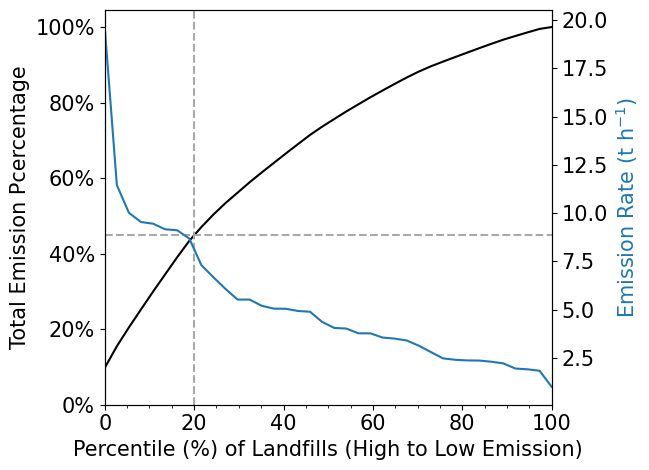

In [21]:
fig, axs = plt.subplots()

plot_cdf(df_emiss.groupby(['country', 'name'], as_index=False).agg({'emission':'mean'})['emission'],
         axs)

axs.set_xlabel('Percentile (%) of Landfills (High to Low Emission)')
axs.set_ylabel('Total Emission Pcercentage')
axs.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

axs.axhline(y=0.45, c='darkgray', linestyle='--')
axs.axvline(x=20, c='darkgray', linestyle='--')
axs.xaxis.set_minor_locator(AutoMinorLocator(4))

axs.set_ylim(ymin=0)
axs.set_xlim(xmin=0, xmax=100)

# plt.text(10, -2.2, 15, c='gray', size=font_size-2)

fig.tight_layout()
# fig.savefig('../figures/emission_cdf.pdf')

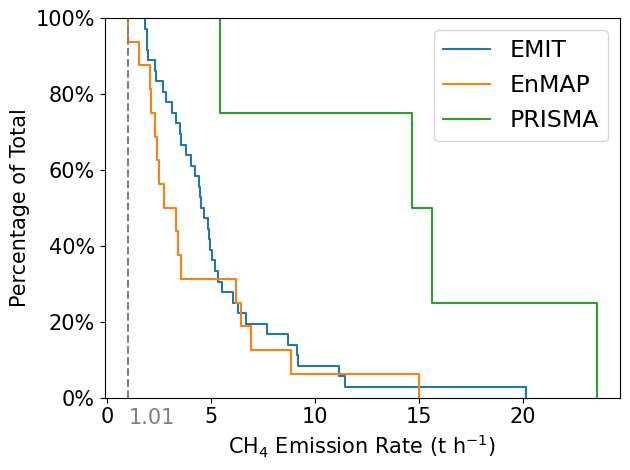

In [22]:
fig, axs = plt.subplots()

axs.ecdf(df_emiss[df_emiss['platform']=='EMIT']['emission'], label='EMIT', complementary=True)
axs.ecdf(df_emiss[df_emiss['platform']=='EnMAP']['emission'], label='EnMAP', complementary=True)
axs.ecdf(df_emiss[df_emiss['platform']=='PRISMA']['emission'], label='PRISMA', complementary=True)

axs.set_xlabel('CH$_4$ Emission Rate (t h$^{-1}$)')
axs.set_ylabel('Percentage of Total')
axs.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plt.axvline(x=df_emiss['emission'].min(), color='gray', linestyle='--')
plt.text(df_emiss['emission'].min(), -0.07, np.round(df_emiss['emission'].min(), 2), c='gray', size=font_size-2)

plt.legend()
fig.tight_layout()
# fig.savefig('../figures/emission_cdf.pdf')

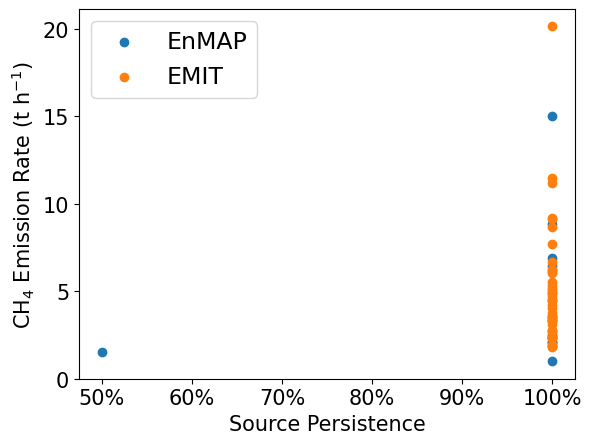

In [23]:
fig, axs = plt.subplots()
plt.scatter(df_emiss[df_emiss['platform']=='EnMAP']['ratio'], df_emiss[df_emiss['platform']=='EnMAP']['emission'], label='EnMAP')
plt.scatter(df_emiss[df_emiss['platform']=='EMIT']['ratio'], df_emiss[df_emiss['platform']=='EMIT']['emission'], label='EMIT')
plt.xlabel('Source Persistence')
axs.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
plt.ylabel('CH$_4$ Emission Rate (t h$^{-1}$)')
plt.ylim(ymin=0)

plt.legend()

## Calculate mean emission and uncertainty

In [24]:
# assume 0 emission for no plume (only EMIT and EnMAP)
df_emiss['emission_mean'] = df_emiss['emission']*df_emiss['plume_count']/df_emiss['overpass']
df_emiss['emission_mean'] = np.where(df_emiss['platform'] == 'PRISMA', df_emiss['emission'], df_emiss['emission_mean'])

df_emiss['emission_ratio'] = df_emiss['emission_mean']/df_emiss['emission']

In [25]:
df_emiss

,country,name,platform,plume_longitude,plume_latitude,emission,emission_uncertainty(%),plume_count,count,overpass,ratio,emission_mean,emission_ratio
0,Argentina,González Catán,EMIT,-58.665998,-34.785059,2.665640,38.406279,3,3,3,1.000000,2.665640,1.0
1,Argentina,González Catán,EnMAP,-58.667128,-34.786969,2.078791,28.743046,2,2,2,1.000000,2.078791,1.0
2,Argentina,Norte III,EMIT,-58.619856,-34.530310,20.177954,30.437862,4,4,4,1.000000,20.177954,1.0
3,Argentina,Norte III,EnMAP,-58.621926,-34.529089,15.032379,26.916566,2,2,2,1.000000,15.032379,1.0
4,Argentina,Norte III,PRISMA,-58.627277,-34.526783,23.567464,28.199555,2,2,2,1.000000,23.567464,1.0
5,Argentina,Piedra Blanca,EMIT,-64.235094,-31.518877,3.557083,34.739416,2,2,2,1.000000,3.557083,1.0
6,Bangladesh,Aminbazar,EMIT,90.299357,23.798009,3.775420,48.865621,1,1,1,1.000000,3.775420,1.0
7,Brazil,Pedreira,EMIT,-46.560920,-23.403868,9.163249,29.928313,1,1,1,1.000000,9.163249,1.0
8,Brazil,São Paulo,EMIT,-46.776142,-23.351949,11.452047,28.628480,1,1,1,1.000000,11.452047,1.0
9,China,Ürümqi,EMIT,87.865791,44.039022,9.113575,29.673030,5,5,5,1.000000,9.113575,1.0


Text(0.5, 0, 'Landfills')

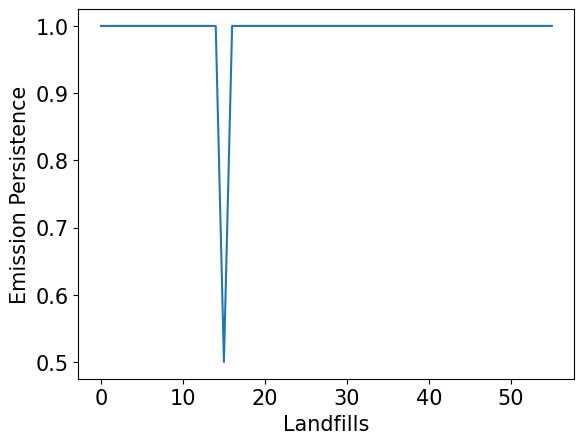

In [26]:
# df_emiss[df_emiss['platform'].isin(['EnMAP', 'EMIT'])].sort_values('emission_ratio')[['country', 'name', 'emission', 'emission_mean','emission_ratio', 'plume_count', 'overpass']]
df_emiss[df_emiss['platform'].isin(['EnMAP', 'EMIT'])]['emission_ratio'].plot()
plt.ylabel('Emission Persistence')
plt.xlabel('Landfills')

## Merge into one csv file

In [27]:
df_summary = df_emiss[['country', 'name', 'platform', 'plume_latitude', 'plume_longitude',
          'emission_mean', 'emission_uncertainty(%)', 'plume_count', 'overpass']]\
            .rename(columns={'plume_latitude': 'latitude', 'plume_longitude': 'longitude', 'emission_mean': 'emission'})
df_summary = df_summary.merge(df[['name', 'emissions_quantity', 'emissions_factor', 'capacity', 'activity', 'metadata_source', 'metadata_report_year']], on='name', how='left')

In [28]:
df_summary

,country,name,platform,latitude,longitude,emission,emission_uncertainty(%),plume_count,overpass,emissions_quantity,emissions_factor,capacity,activity,metadata_source,metadata_report_year
0,Argentina,González Catán,EMIT,-34.785059,-58.665998,2.665640,38.406279,3,3,19079.02,0.041004,1200000.00,465297.85,Waste Atlas,2013.0
1,Argentina,González Catán,EnMAP,-34.786969,-58.667128,2.078791,28.743046,2,2,19079.02,0.041004,1200000.00,465297.85,Waste Atlas,2013.0
2,Argentina,Norte III,EMIT,-34.530310,-58.619856,20.177954,30.437862,4,4,28528.14,0.045643,900000.00,625026.97,Waste Atlas,2013.0
3,Argentina,Norte III,EnMAP,-34.529089,-58.621926,15.032379,26.916566,2,2,28528.14,0.045643,900000.00,625026.97,Waste Atlas,2013.0
4,Argentina,Norte III,PRISMA,-34.526783,-58.627277,23.567464,28.199555,2,2,28528.14,0.045643,900000.00,625026.97,Waste Atlas,2013.0
5,Argentina,Piedra Blanca,EMIT,-31.518877,-64.235094,3.557083,34.739416,2,2,14902.44,0.041850,NaN,356094.72,METER/OSM,2022.0
6,Bangladesh,Aminbazar,EMIT,23.798009,90.299357,3.775420,48.865621,1,1,13506.95,0.046725,NaN,289072.51,METER/OSM,2022.0
7,Brazil,Pedreira,EMIT,-23.403868,-46.560920,9.163249,29.928313,1,1,NaN,NaN,NaN,NaN,NaN,NaN
8,Brazil,São Paulo,EMIT,-23.351949,-46.776142,11.452047,28.628480,1,1,NaN,NaN,NaN,NaN,NaN,NaN
9,China,Ürümqi,EMIT,44.039022,87.865791,9.113575,29.673030,5,5,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
df_summary[df_summary['platform']=='PRISMA']

,country,name,platform,latitude,longitude,emission,emission_uncertainty(%),plume_count,overpass,emissions_quantity,emissions_factor,capacity,activity,metadata_source,metadata_report_year
4,Argentina,Norte III,PRISMA,-34.526783,-58.627277,23.567464,28.199555,2,2,28528.14,0.045643,900000.00,625026.97,Waste Atlas,2013.0
21,India,Kanjurmarg,PRISMA,19.122098,72.954768,15.639922,24.455899,2,2,3872.44,0.050050,38354.50,77371.17,Global Plastic Watch,2021.0
27,India,Pirana,PRISMA,22.982818,72.569787,5.433425,31.354637,5,28,19285.05,0.048327,649995.49,399053.89,Waste Atlas,2013.0
46,Pakistan,Lakhodair,PRISMA,31.625760,74.420060,14.654155,29.194466,1,2,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
df_summary.to_csv('../data/landfills_hyper_summary.csv', index=False)

In [30]:
df_emiss = df_summary.groupby(['country', 'name'], as_index=False)\
    .agg({'emission':'mean', 'emission_uncertainty(%)': 'mean', 'latitude': 'mean', 'longitude': 'mean'})

df_emiss = df_emiss[['country', 'name', 'latitude', 'longitude',
            'emission',	'emission_uncertainty(%)',
            ]]\
                .rename(columns={'country': 'Country', 'name': 'Landfill Name',
                                 'latitude': 'Latitude', 'longitude': 'Longitude',
                                 'emission': 'Emission (t/h)', 'emission_uncertainty(%)': 'Uncertainty (%)',
                                 }
                        )

df_emiss['Uncertainty (t/h)'] = df_emiss['Emission (t/h)'] * df_emiss['Uncertainty (%)'] * 1e-2
# move to the last column
df_emiss['Uncertainty (%)'] = df_emiss.pop('Uncertainty (%)')

In [31]:
df_emiss

,Country,Landfill Name,Latitude,Longitude,Emission (t/h),Uncertainty (t/h),Uncertainty (%)
0,Argentina,González Catán,-34.786014,-58.666563,2.372215,0.796463,33.574662
1,Argentina,Norte III,-34.528727,-58.623020,19.592599,5.587416,28.517994
2,Argentina,Piedra Blanca,-31.518877,-64.235094,3.557083,1.235710,34.739416
3,Bangladesh,Aminbazar,23.798009,90.299357,3.775420,1.844882,48.865621
4,Brazil,Pedreira,-23.403868,-46.560920,9.163249,2.742406,29.928313
5,Brazil,São Paulo,-23.351949,-46.776142,11.452047,3.278547,28.628480
6,China,Ürümqi,44.039022,87.865791,9.113575,2.704274,29.673030
7,India,Bandhwari,28.402329,77.172110,2.364700,0.770851,32.598266
8,India,Bhalswa,28.741571,77.156534,2.218554,0.726758,32.758174
9,India,Deonar,19.072684,72.928106,2.025497,0.647515,31.968207


In [32]:
print(df_emiss.to_latex(index=False, float_format=lambda x: '%10.1f' % x))

\begin{tabular}{llrrrrr}
\toprule
      Country &            Landfill Name &   Latitude &  Longitude &  Emission (t/h) &  Uncertainty (t/h) &  Uncertainty (\%) \\
\midrule
    Argentina &           González Catán &      -34.8 &      -58.7 &             2.4 &                0.8 &             33.6 \\
    Argentina &                Norte III &      -34.5 &      -58.6 &            19.6 &                5.6 &             28.5 \\
    Argentina &            Piedra Blanca &      -31.5 &      -64.2 &             3.6 &                1.2 &             34.7 \\
   Bangladesh &                Aminbazar &       23.8 &       90.3 &             3.8 &                1.8 &             48.9 \\
       Brazil &                 Pedreira &      -23.4 &      -46.6 &             9.2 &                2.7 &             29.9 \\
       Brazil &                São Paulo &      -23.4 &      -46.8 &            11.5 &                3.3 &             28.6 \\
        China &                   Ürümqi &       44.0 &     

/var/folders/cq/3gpzzbcn09v0cq17f4n6hjcr0000gn/T/ipykernel_33522/108015037.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_emiss.to_latex(index=False, float_format=lambda x: '%10.1f' % x))


In [33]:
df_emiss.columns

Index(['Country', 'Landfill Name', 'Latitude', 'Longitude', 'Emission (t/h)',
       'Uncertainty (t/h)', 'Uncertainty (%)'],
      dtype='object')

In [34]:
df_emiss_country = df_emiss.groupby(['Country'], as_index=False)\
    .agg({'Emission (t/h)': 'sum',
          'Uncertainty (t/h)': lambda x: np.sqrt(sum(x**2)),
          })
df_emiss_country['Uncertainty (%)'] = df_emiss_country['Uncertainty (t/h)'] / df_emiss_country['Emission (t/h)']  * 1e2
# df_emiss_country['Uncertainty (t/h)'] = df_emiss_country['Emission (t/h)'] * df_emiss_country['Uncertainty (%)'] * 1e-2

In [35]:
df_emiss_country

,Country,Emission (t/h),Uncertainty (t/h),Uncertainty (%)
0,Argentina,25.521897,5.777591,22.637779
1,Bangladesh,3.775420,1.844882,48.865621
2,Brazil,20.615297,4.274302,20.733645
3,China,9.113575,2.704274,29.673030
4,India,38.028935,4.235759,11.138253
5,Iran,8.548050,1.896416,22.185364
6,Israel,9.888136,2.302153,23.281969
7,Jordan,10.080441,2.346301,23.275783
8,Kuwait,7.305856,2.208587,30.230360
9,Mexico,19.904103,3.244222,16.299263


In [36]:
print('Total CH4 emission (t/h): ', df_emiss_country['Emission (t/h)'].sum(),
      ', uncertainty (t/h): ', np.sqrt(sum(df_emiss_country['Uncertainty (t/h)']**2))
)

Total CH4 emission (t/h):  200.10598749852417 , uncertainty (t/h):  11.93001188530142


In [37]:
print(df_emiss_country.to_latex(index=False, float_format=lambda x: '%10.1f' % x))

\begin{tabular}{lrrr}
\toprule
      Country &  Emission (t/h) &  Uncertainty (t/h) &  Uncertainty (\%) \\
\midrule
    Argentina &            25.5 &                5.8 &             22.6 \\
   Bangladesh &             3.8 &                1.8 &             48.9 \\
       Brazil &            20.6 &                4.3 &             20.7 \\
        China &             9.1 &                2.7 &             29.7 \\
        India &            38.0 &                4.2 &             11.1 \\
         Iran &             8.5 &                1.9 &             22.2 \\
       Israel &             9.9 &                2.3 &             23.3 \\
       Jordan &            10.1 &                2.3 &             23.3 \\
       Kuwait &             7.3 &                2.2 &             30.2 \\
       Mexico &            19.9 &                3.2 &             16.3 \\
     Pakistan &            14.7 &                3.7 &             25.4 \\
 Saudi Arabia &            10.0 &                2.7 &     

/var/folders/cq/3gpzzbcn09v0cq17f4n6hjcr0000gn/T/ipykernel_33522/2512086831.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_emiss_country.to_latex(index=False, float_format=lambda x: '%10.1f' % x))
